In [1]:
from matplotlib import pylab as plt
from itertools import compress
import xml.etree.ElementTree as ET
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from ase import Atoms, Atom

from tqdm.notebook import tqdm

from time import time
import math

import ase
from ase.io import read, write
from ase.visualize import view
from ase.geometry import wrap_positions
from ase.calculators.singlepoint import SinglePointCalculator
import numpy as np

In [2]:
def EF_baseline(frame, f, r_cut):
    
    '''
    
    f is the function of the baseline, it should take the distance r as the only input. 
    When using CubicSpline() to fit the baseline function f, please set 'extrapolate' = False.
    The unit of function f should be eV/atom.
    
    r_cut is the cut-off radius, only atoms within this radius will be considered.
    
    frame is an Atoms object, for each atom in this Atoms object, we calculate its 
    distance to other atoms within the cutoff radius and substract the baseline energy.
    
    '''
    
    f_deri = f.derivative() # don't forget the minus sign below
    
    vec_cell = frame.cell.cellpar()
    M1, M2, M3 = vec_cell[0]**2, vec_cell[1]**2, vec_cell[2]**2
    M12 = vec_cell[0]*vec_cell[1]*np.cos(vec_cell[5]*np.pi/180)
    M13 = vec_cell[0]*vec_cell[2]*np.cos(vec_cell[4]*np.pi/180)
    M23 = vec_cell[1]*vec_cell[2]*np.cos(vec_cell[3]*np.pi/180)
    det_M = M1*M2*M3-M1*M23**2-M2*M13**2-M3*M12**2+2*M12*M13*M23
    N1=math.ceil(np.sqrt((M2*M3-M23**2)/det_M)*r_cut)
    N2=math.ceil(np.sqrt((M1*M3-M13**2)/det_M)*r_cut)
    N3=math.ceil(np.sqrt((M1*M2-M12**2)/det_M)*r_cut)
    
    pbc = frame.get_pbc()
    number = len(frame)
    
    cell_size = [(2*N1+1) if pbc[0] else 1,
                  (2*N2+1) if pbc[1] else 1, 
                  (2*N3+1) if pbc[2] else 1]
    center_index = math.floor(np.prod(cell_size)/2)
    il = center_index*number
    ih = (center_index+1)*number
    
    frame2=frame*(cell_size[0],cell_size[1],cell_size[2])

    frc_list = np.zeros((number,3))
    base_energy = 0
    
    dist_idx = np.arange((len(frame2)))
    
    for i in range(il,ih):
        i_energy=0
        # i actually corresponds to the i-th row of get_all_distances(), which is the distances from the i+1 th atom to all atoms.
        i_distances = frame2.get_distances(i,dist_idx)
        for j in dist_idx:
            if str(f(i_distances[j])) != 'nan':
                if center_index*number <= j < (center_index+1)*number:
                    i_energy += float(f(i_distances[j]))/2
                    frc_norm = -f_deri(i_distances[j])
                    rel_vec = normalize( frame2[i].position - frame2[j].position )
                    frc_vec = frc_norm * rel_vec
                    frc_list[i-il,0] += frc_vec[0]
                    frc_list[i-il,1] += frc_vec[1]
                    frc_list[i-il,2] += frc_vec[2]
                else:
                    i_energy += float(f(i_distances[j]))
                    frc_norm = -f_deri(i_distances[j])
                    rel_vec = normalize( frame2[i].position - frame2[j].position )
                    frc_vec = frc_norm * rel_vec
                    frc_list[i-il,0] += frc_vec[0]
                    frc_list[i-il,1] += frc_vec[1]
                    frc_list[i-il,2] += frc_vec[2]
            else:
                pass    
        base_energy += i_energy
    return base_energy, frc_list


def normalize(v):
    '''
    v is a numpy array
    '''
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

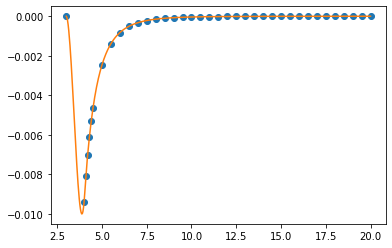

In [3]:
# Obtain the R6 baseline function

# Read data from .xml file and extract the distance-energy value.
tree = ET.parse('P_r6_innercut.xml')
root = tree.getroot()

r=[]
energy=[]
for i in root.iter('potential_pair'):
    for j in i.iter():
        if j.tag != 'potential_pair':
            r.append(float(j.attrib['r']))
            energy.append(float(j.attrib['E']))
        else:
            pass

energy=np.array(energy)/2
r=np.array(r)

r_new = np.linspace(2.8,20,500)


### base_func is the ultimate baseline function! Its domain is [3,20].

base_func = CubicSpline(r, energy, bc_type = 'clamped',extrapolate = False)
plt.plot(r, energy, 'o', r_new, base_func(r_new), '-')
plt.show()

In [4]:
N = 100
frames = read('exfoliation_mbd_reference.xyz', index=':{}'.format(N))

for frame in frames:
    frame.set_positions(wrap_positions(frame.get_positions(),frame.get_cell(),eps=1e-10))

# for some frames, stress is not available, so we omit it.
start = time()
for frame in tqdm(frames):
    e = frame.calc.results['energy'] - EF_baseline(frame, base_func, 20.)[0]
    f = frame.calc.results['forces'] - EF_baseline(frame, base_func, 20.)[1]
    frame.calc = SinglePointCalculator(atoms=frame,energy=e,
                                       forces=f,
                                      )
print ("Execution time: ", time()-start, "s")

  0%|          | 0/100 [00:00<?, ?it/s]

Execution time:  84.9412772655487 s


In [5]:
write('exfoliation_mbd_no_baseline.xyz',frames)

/home/haoran/.local/lib/python3.8/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '
